In [1]:
# ────────────────────────────── 0. Imports ───────────────────────────────
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (f1_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix,
                             precision_recall_curve, roc_curve, auc)

import tensorflow as tf
from tensorflow import keras
from keras.layers import (Input, Embedding, Dense, Dropout, LayerNormalization,
                          Add, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D,
                          concatenate, MultiHeadAttention, GlobalAveragePooling1D)
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras import backend as K

from datetime import datetime
LOG_DIR = f"logs/{datetime.now():%Y%m%d-%H%M%S}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(
        log_dir=LOG_DIR,
        histogram_freq=1,
        write_graph=True,
        write_images=False)

2025-05-17 00:43:01.652946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/leanderengel/Desktop/advanced pa/advanced-topics-predictive-group-j/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# ───────────────────────────── 1. Hyper-params ────────────────────────────
MAX_WORDS   = 20_000       # size of the word vocabulary
MAX_LEN     = 32           # sequence length after padding / truncation
BATCH_SIZE  = 32
EPOCHS      = 20
PATIENCE_ES = 3            # EarlyStopping patience
PATIENCE_LR = 2            # LR-scheduler patience
SEED        = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# ───────────────────────────── 2. Load & Clean ───────────────────────────
DATA_DIR = Path('../data/goemotions')

df = pd.concat([pd.read_csv(p) for p in DATA_DIR.glob('goemotions_*.csv')],
               ignore_index=True)

def basic_clean(text: str) -> str:
    """Lower-case, drop HTML, punctuation, duplicate spaces."""
    text = re.sub(r'<.*?>', '', text.lower())          # remove HTML
    text = re.sub(r'[^a-z0-9\s]', '', text)            # keep alphanum/space
    return re.sub(r'\s+', ' ', text).strip()

df['clean_text'] = df['text'].astype(str).apply(basic_clean)

# -------------------------------------------------------------------------
# Make sure emotion columns are numeric (int8 saves RAM)
# -------------------------------------------------------------------------
META = {'text','id','author','subreddit','link_id','parent_id',
        'created_utc','rater_id','example_very_unclear'}
label_cols = [c for c in df.columns if c not in META and c != 'clean_text']
df[label_cols] = df[label_cols].astype('int8')

In [4]:
# ───────────────────────────── 3. Train / Val / Test split ───────────────
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED)
val_df,   test_df = train_test_split(temp_df, test_size=0.5, random_state=SEED)

In [5]:
# ───────────────────────────── 4. Tokenisation ───────────────────────────
# 4-a Build vocabulary on the training set
counter = Counter(); [counter.update(t.split()) for t in train_df['clean_text']]
vocab = [w for w,_ in counter.most_common(MAX_WORDS-1)]
word2idx = {w:i+2 for i,w in enumerate(vocab)}  # 0=PAD,1=OOV
VOCAB_SIZE = MAX_WORDS + 2

def text_to_ids(txt): return [word2idx.get(tok,1) for tok in txt.split()]
def pad32(seq): return (seq[:MAX_LEN] + [0]*MAX_LEN)[:MAX_LEN]
def to_tensor(series): return np.array([pad32(text_to_ids(t)) for t in series],
                                       dtype=np.int16)

train_x = to_tensor(train_df['clean_text'])
val_x   = to_tensor(val_df['clean_text'])
test_x  = to_tensor(test_df['clean_text'])

train_y = train_df[label_cols].values
val_y   = val_df[label_cols].values
test_y  = test_df[label_cols].values
N_LABELS = len(label_cols)

In [6]:
# ─────────── 4-bis-prep. Derive positive / negative flags if missing ─────
if 'positive' not in df.columns:
    pos_emotions = ['admiration','amusement','approval','caring','desire',
                    'excitement','gratitude','joy','love','optimism',
                    'pride','relief']
    neg_emotions = ['anger','annoyance','confusion','disappointment',
                    'disapproval','disgust','embarrassment','fear','grief',
                    'nervousness','remorse','sadness']
    missing = set(pos_emotions + neg_emotions) - set(label_cols)
    if missing:
        raise ValueError(f'Missing emotion columns: {missing}')
    df['positive'] = (df[pos_emotions].sum(axis=1) > 0).astype('int8')
    df['negative'] = (df[neg_emotions].sum(axis=1) > 0).astype('int8')
    print('Derived positive / negative flags.')
else:
    print('positive / negative already present.')

Derived positive / negative flags.


In [7]:
# ░░░░░░░░░░░ 4-bis. Binary Sentiment Dataset (GoEmotions) ░░░░░░░░░░░
print('\n=== Building binary sentiment subset ===')

mask_bin = (df['positive']==1) ^ (df['negative']==1)
sent_df  = df.loc[mask_bin, ['clean_text','positive']].copy()
sent_df.rename(columns={'positive':'label'}, inplace=True)

X_train_txt, X_test_txt, y_train_bin, y_test_bin = train_test_split(
    sent_df['clean_text'], sent_df['label'],
    test_size=0.2, random_state=SEED, stratify=sent_df['label']
)
X_train_bin = to_tensor(X_train_txt)
X_test_bin  = to_tensor(X_test_txt)

print(f'Train {len(X_train_bin):,} samples  pos-ratio {y_train_bin.mean():.2f}')

def build_sentiment_cnn():
    inp = Input((MAX_LEN,))
    x   = Embedding(VOCAB_SIZE, 128)(inp)
    x   = Conv1D(128, 5, activation='relu')(x)
    x   = GlobalMaxPooling1D()(x)
    x   = Dropout(0.5)(x)
    out = Dense(1, activation='sigmoid')(x)
    m   = keras.Model(inp, out)
    m.compile(Adam(1e-3), 'binary_crossentropy', metrics=['accuracy'])
    return m

sent_cnn = build_sentiment_cnn()
sent_cnn.fit(X_train_bin, y_train_bin,
             validation_split=0.1,
             epochs=6, batch_size=128,
             callbacks=[keras.callbacks.EarlyStopping(patience=2,
                                                      restore_best_weights=True)],
             verbose=2)
print(f'Binary sentiment accuracy: {sent_cnn.evaluate(X_test_bin, y_test_bin, verbose=0)[1]:.3f}')
sent_cnn.save('sentiment_goemotions_cnn.keras')
print('Saved -> sentiment_goemotions_cnn.keras\n')


=== Building binary sentiment subset ===
Train 104,800 samples  pos-ratio 0.58
Epoch 1/6
737/737 - 41s - 55ms/step - accuracy: 0.7829 - loss: 0.4500 - val_accuracy: 0.8276 - val_loss: 0.3880
Epoch 2/6
737/737 - 35s - 48ms/step - accuracy: 0.8483 - loss: 0.3505 - val_accuracy: 0.8294 - val_loss: 0.3912
Epoch 3/6
737/737 - 36s - 49ms/step - accuracy: 0.8696 - loss: 0.3058 - val_accuracy: 0.8291 - val_loss: 0.4144
Binary sentiment accuracy: 0.823
Saved -> sentiment_goemotions_cnn.keras



In [8]:
# ───────────────────────────── 5. Class Weights ──────────────────────────
pos = train_y.sum(axis=0)
neg = len(train_y) - pos
# inverse frequency; cap very rare labels to 25× weight
class_weight = {i: float(np.clip(neg[i] / pos[i], 1.0, 25.0))
                for i in range(N_LABELS)}

In [9]:
# ───────────────────────────── 6. Macro-F1 Callback ──────────────────────
class MacroF1(Callback):
    """Compute macro-F1 on validation set after each epoch."""
    def __init__(self, val_data):
        super().__init__()
        self.val_x, self.val_y = val_data
        self.history = []

    def on_epoch_end(self, epoch, logs=None):
        preds = (self.model.predict(self.val_x, verbose=0) > 0.5).astype(int)
        f1 = f1_score(self.val_y, preds, average='macro')
        self.history.append(f1)
        print(f' — val_macro_f1: {f1:.4f}')

In [10]:
# ───────────────────────────── 7. Encoder Blocks ─────────────────────────
def build_lstm(emb_dim=100, units=128):
    inp = Input(shape=(MAX_LEN,))
    x   = Embedding(VOCAB_SIZE, emb_dim)(inp)
    x   = Bidirectional(LSTM(units))(x)
    x   = Dropout(0.5)(x)
    out = Dense(N_LABELS, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
    return model

def build_cnn(emb_dim=100, filters=64, kernel_sizes=(3,4,5)):
    inp = Input(shape=(MAX_LEN,))
    x   = Embedding(VOCAB_SIZE, emb_dim)(inp)
    pooled = [GlobalMaxPooling1D()(Conv1D(filters, k, activation='relu')(x))
              for k in kernel_sizes]
    x   = concatenate(pooled)
    x   = Dropout(0.5)(x)
    out = Dense(N_LABELS, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
    return model

# ---- tiny Transformer encoder ------------------------------------------
def tfm_block(x, heads=4, proj=64, mlp_dim=128):
    """One transformer encoder block with residual connections."""
    attn_out = MultiHeadAttention(num_heads=heads, key_dim=proj)(x, x)
    x = LayerNormalization()(Add()([x, attn_out]))

    mlp_out = Dense(mlp_dim, activation='relu')(x)
    mlp_out = Dense(x.shape[-1])(mlp_out)
    return LayerNormalization()(Add()([x, mlp_out]))

def build_transformer(emb_dim=128, blocks=2, heads=4):
    inp = Input(shape=(MAX_LEN,))
    tok_emb = Embedding(VOCAB_SIZE, emb_dim)(inp)
    # learnable positional embedding
    pos_emb = Embedding(MAX_LEN, emb_dim)(tf.range(MAX_LEN)[None, :])
    x = tok_emb + pos_emb

    for _ in range(blocks):
        x = tfm_block(x, heads, emb_dim // heads, emb_dim * 2)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    out = Dense(N_LABELS, activation='sigmoid')(x)
    model = keras.Model(inp, out)
    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
    return model
# ------------------------------------------------------------------------

# Common callbacks
CALLBACKS = [
    keras.callbacks.EarlyStopping(patience=PATIENCE_ES, restore_best_weights=True,
                                  min_delta=1e-4),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=PATIENCE_LR,
                                      min_lr=1e-6, verbose=1),
    tensorboard_cb   
]

def train_model(build_fn, name):
    """Utility: build, fit, return trained model + F1 curve."""
    K.clear_session()                                   # free GPU/CPU memory
    model = build_fn()
    f1_cb = MacroF1((val_x, val_y))
    model.fit(train_x, train_y,
              validation_data=(val_x, val_y),
              epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              class_weight=class_weight,
              callbacks=[f1_cb, *CALLBACKS],
              verbose=2)
    return model, f1_cb.history

In [11]:
# ───────────────────────────── 7.1 Hyperparameter Tuning ────────────────────────
def hyperparameter_search_cnn_efficient():
    """More efficient grid search for CNN hyperparameters."""
    print("\n=== CNN Hyperparameter Tuning (Efficient) ===")
    best_f1 = 0
    best_params = {}
    results = []
    
    # Check if GPU is available
    gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
    print(f"GPU available: {gpu_available}")
    
    # Smaller parameter grid
    param_grid = {
        'emb_dim': [100],          # Reduced from [50, 100, 200]
        'filters': [64, 128],       # Reduced from [32, 64, 128]
        'dropout': [0.5]            # Reduced from [0.3, 0.5, 0.7]
    }
    
    # Create a smaller subset for faster tuning
    sample_size = min(5000, len(train_x))
    indices = np.random.choice(len(train_x), sample_size, replace=False)
    train_x_sample = train_x[indices]
    train_y_sample = train_y[indices]
    
    print(f"Using {sample_size} samples for tuning (from {len(train_x)} total)")
    
    # Display total combinations
    total_combinations = len(param_grid['emb_dim']) * len(param_grid['filters']) * len(param_grid['dropout'])
    print(f"Testing {total_combinations} parameter combinations")
    
    for emb_dim in param_grid['emb_dim']:
        for filters in param_grid['filters']:
            for dropout in param_grid['dropout']:
                params = {
                    'emb_dim': emb_dim,
                    'filters': filters,
                    'dropout': dropout
                }
                print(f"\nTesting: emb_dim={emb_dim}, filters={filters}, dropout={dropout}")
                
                # Define model with these hyperparameters
                def build_model():
                    inp = Input(shape=(MAX_LEN,))
                    x = Embedding(VOCAB_SIZE, emb_dim)(inp)
                    pooled = [GlobalMaxPooling1D()(Conv1D(filters, k, activation='relu')(x))
                             for k in [3, 4, 5]]
                    x = concatenate(pooled)
                    x = Dropout(dropout)(x)
                    out = Dense(N_LABELS, activation='sigmoid')(x)
                    model = keras.Model(inp, out)
                    model.compile(Adam(1e-3), 'binary_crossentropy', metrics=['binary_accuracy'])
                    return model
                
                # Train with fewer epochs for hyperparameter search
                K.clear_session()
                model = build_model()
                f1_cb = MacroF1((val_x, val_y))
                
                history = model.fit(
                    train_x_sample, train_y_sample,  # Using sampled data
                    validation_data=(val_x, val_y),
                    epochs=3,  # Reduced epochs for faster tuning
                    batch_size=BATCH_SIZE,
                    callbacks=[f1_cb],  # Reduced callbacks
                    class_weight=class_weight,
                    verbose=1
                )
                
                # Get best F1 score
                val_f1 = max(f1_cb.history)
                
                # Track results
                results.append({**params, 'val_f1': val_f1})
                
                if val_f1 > best_f1:
                    best_f1 = val_f1
                    best_params = params
                
                # Free memory
                K.clear_session()
    
    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    
    print(f"\nBest parameters: {best_params}, F1: {best_f1:.4f}")
    print("\nAll configurations:")
    print(results_df.sort_values('val_f1', ascending=False).to_string(index=False))
    
    return best_params

In [12]:
# ───────────────────────────── 7.2 Cross-Validation ────────────────────────
def cross_validate_model_efficient(build_fn, name, k=3):
    """Perform k-fold cross-validation on the model with efficiency optimizations."""
    print(f"\n=== {name} {k}-Fold Cross-Validation (Efficient) ===")
    
    # Create k folds with fewer splits
    kf = KFold(n_splits=k, shuffle=True, random_state=SEED)
    
    # Combine train and validation data for CV
    combined_x = np.concatenate([train_x, val_x])
    combined_y = np.concatenate([train_y, val_y])
    
    # Take a sample to speed up cross-validation
    sample_size = min(10000, len(combined_x))
    indices = np.random.choice(len(combined_x), sample_size, replace=False)
    combined_x_sample = combined_x[indices]
    combined_y_sample = combined_y[indices]
    
    print(f"Using {sample_size} samples for CV (from {len(combined_x)} total)")
    
    fold_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(combined_x_sample)):
        print(f"\nTraining fold {fold+1}/{k}")
        
        # Get fold data
        fold_train_x = combined_x_sample[train_idx]
        fold_train_y = combined_y_sample[train_idx]
        fold_val_x = combined_x_sample[val_idx]
        fold_val_y = combined_y_sample[val_idx]
        
        # Build and train model
        K.clear_session()
        model = build_fn()
        f1_cb = MacroF1((fold_val_x, fold_val_y))
        
        model.fit(
            fold_train_x, fold_train_y,
            validation_data=(fold_val_x, fold_val_y),
            epochs=5,  # Further reduced epochs
            batch_size=BATCH_SIZE * 2,  # Larger batch size for speed
            callbacks=[f1_cb],  # Minimal callbacks
            class_weight=class_weight,
            verbose=1
        )
        
        # Get best F1 score
        best_f1 = max(f1_cb.history)
        fold_scores.append(best_f1)
        
        print(f"Fold {fold+1} best F1: {best_f1:.4f}")
    
    # Calculate aggregate statistics
    mean_f1 = np.mean(fold_scores)
    std_f1 = np.std(fold_scores)
    
    # Print summary
    print(f"\n{name} Cross-validation results:")
    print(f"F1 scores: {[f'{x:.4f}' for x in fold_scores]}")
    print(f"Mean F1: {mean_f1:.4f}, Std: {std_f1:.4f}")
    
    return {'f1_scores': fold_scores, 'mean_f1': mean_f1, 'std_f1': std_f1}

In [13]:
# ───────────────────────────── 8. Train all three encoders ───────────────
lstm_model, hist_lstm = train_model(build_lstm, 'LSTM')
cnn_model,  hist_cnn  = train_model(build_cnn,  'CNN')
tfm_model,  hist_tfm  = train_model(build_transformer, 'TFM')

Epoch 1/20
 — val_macro_f1: 0.1473
5281/5281 - 312s - 59ms/step - binary_accuracy: 0.9591 - loss: 2.3062 - val_binary_accuracy: 0.9602 - val_loss: 0.1349 - learning_rate: 0.0010
Epoch 2/20
 — val_macro_f1: 0.1794
5281/5281 - 317s - 60ms/step - binary_accuracy: 0.9598 - loss: 1.9905 - val_binary_accuracy: 0.9603 - val_loss: 0.1312 - learning_rate: 0.0010
Epoch 3/20
 — val_macro_f1: 0.1982
5281/5281 - 319s - 60ms/step - binary_accuracy: 0.9601 - loss: 1.8933 - val_binary_accuracy: 0.9601 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 4/20
 — val_macro_f1: 0.2176
5281/5281 - 4204s - 796ms/step - binary_accuracy: 0.9603 - loss: 1.8299 - val_binary_accuracy: 0.9599 - val_loss: 0.1307 - learning_rate: 0.0010
Epoch 5/20
 — val_macro_f1: 0.2284

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
5281/5281 - 772s - 146ms/step - binary_accuracy: 0.9604 - loss: 1.7797 - val_binary_accuracy: 0.9597 - val_loss: 0.1314 - learning_rate: 0.0010
Epoch 6/20
 — val_macro_f1: 0.

In [14]:
# ───────────────────────────── 9. Per-class threshold tuning ─────────────
# Use Transformer as best model; you can reuse this function for others.
val_prob = tfm_model.predict(val_x, batch_size=256, verbose=0)
opt_thr  = np.zeros(N_LABELS)

for i in range(N_LABELS):
    precision, recall, thresh = precision_recall_curve(val_y[:, i], val_prob[:, i])
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    opt_thr[i] = thresh[f1.argmax()]

np.save('opt_thresholds.npy', opt_thr)   #  -> used later in Part 2/3

In [15]:
# ───────────────────────────── 10. Final Test metrics ────────────────────
def evaluate(model, name, thr=None):
    prob = model.predict(test_x, batch_size=256, verbose=0)
    pred = (prob >= thr) if thr is not None else (prob > 0.5)
    pred = pred.astype(int)
    macro = f1_score(test_y, pred, average='macro')
    micro = f1_score(test_y, pred, average='micro')
    print(f'{name:11s} | Macro-F1 {macro:.4f} | Micro-F1 {micro:.4f}')

print('\n── Test set with fixed 0.5 threshold ──')
evaluate(lstm_model, 'Bi-LSTM')
evaluate(cnn_model,  '1D-CNN')

print('\n── Test set with tuned thresholds (Transformer) ──')
evaluate(tfm_model, 'Transformer', opt_thr)


── Test set with fixed 0.5 threshold ──
Bi-LSTM     | Macro-F1 0.1927 | Micro-F1 0.2293
1D-CNN      | Macro-F1 0.2095 | Micro-F1 0.2312

── Test set with tuned thresholds (Transformer) ──
Transformer | Macro-F1 0.3346 | Micro-F1 0.3831


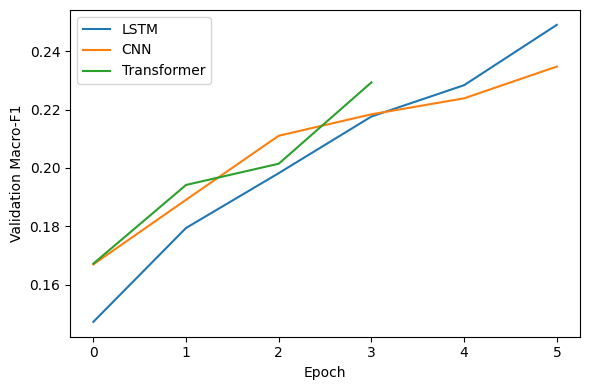

In [16]:
# ───────────────────────────── 11. F1 curves plot ────────────────────────
plt.figure(figsize=(6, 4))
plt.plot(hist_lstm, label='LSTM')
plt.plot(hist_cnn,  label='CNN')
plt.plot(hist_tfm,  label='Transformer')
plt.ylabel('Validation Macro-F1'); plt.xlabel('Epoch'); plt.legend(); plt.tight_layout()
plt.show()

In [ ]:
# ───────────────────────────── 12 & 13.  Evaluation / Visual helpers ─────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (precision_recall_fscore_support,
                             confusion_matrix, roc_curve, auc, f1_score)
import pandas as pd


# ───────────────────────── evaluate_model_comprehensive ──────────────────
def evaluate_model_comprehensive(model, x_test, y_test, label_cols,
                                 thresholds=None, name="Model"):
    """Return a per-class metrics DataFrame + print macro/micro F1."""
    y_prob = model.predict(x_test, batch_size=256, verbose=0)
    if thresholds is not None:
        y_pred = np.stack([
            (y_prob[:, i] >= thresholds[i]).astype(int)
            for i in range(y_prob.shape[1])
        ], axis=1)
    else:
        y_pred = (y_prob > 0.5).astype(int)

    prec, rec, f1, support = precision_recall_fscore_support(
        y_test, y_pred, average=None, zero_division=0)

    metrics_df = (pd.DataFrame({
        "Emotion":   label_cols,
        "Precision": prec,
        "Recall":    rec,
        "F1-Score":  f1,
        "Support":   support,
        "Threshold": thresholds if thresholds is not None else [0.5]*len(label_cols)
    })
    .sort_values("F1-Score", ascending=False))

    macro = f1_score(y_test, y_pred, average="macro", zero_division=0)
    micro = f1_score(y_test, y_pred, average="micro", zero_division=0)
    print(f"\n{name}  —  Macro-F1 {macro:.4f} | Micro-F1 {micro:.4f}")

    return metrics_df


# ───────────────────────── plot_metrics_by_emotion ───────────────────────
def plot_metrics_by_emotion(metrics_df, title="Model Performance", n_emotions=10):
    top = metrics_df.head(n_emotions)
    x = np.arange(len(top))
    width = 0.25

    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(["Precision", "Recall", "F1-Score"]):
        plt.bar(x + (i-1)*width, top[metric], width=width, label=metric)

    for i, row in top.iterrows():
        plt.text(i, 1.02, f'n={row.Support}\nthr={row.Threshold:.2f}',
                 ha="center", va="bottom", fontsize=8)

    plt.xticks(x, top["Emotion"], rotation=45, ha="right")
    plt.ylim(0, 1.15)
    plt.title(title)
    plt.grid(axis="y", alpha=0.4)
    plt.legend()
    plt.gcf().tight_layout()
    plt.show()


# ───────────────────────── plot_confusion_matrix_for_class ───────────────
def plot_confusion_matrix_for_class(model, x_test, y_test,
                                    class_idx, class_name,
                                    threshold=0.5):
    prob = model.predict(x_test, batch_size=256, verbose=0)[:, class_idx]
    pred = (prob >= threshold).astype(int)
    true = y_test[:, class_idx]
    cm   = confusion_matrix(true, pred)

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, cmap="Blues")
    plt.colorbar()
    plt.xticks([0, 1], ["Neg", "Pos"])
    plt.yticks([0, 1], ["Neg", "Pos"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, v, ha="center", va="center")
    plt.title(f"{class_name} confusion")
    plt.gcf().tight_layout()
    plt.show()


# ───────────────────────── analyze_error_patterns ────────────────────────
def analyze_error_patterns(model, x_test, y_test, label_cols, thresholds=None):
    prob = model.predict(x_test, batch_size=256, verbose=0)
    pred = (prob >= thresholds) if thresholds is not None else (prob > 0.5)
    pred = pred.astype(int)

    fp = ((pred == 1) & (y_test == 0)).sum(axis=0)
    fn = ((pred == 0) & (y_test == 1)).sum(axis=0)
    err_df = (pd.DataFrame({"Emotion": label_cols, "FP": fp, "FN": fn})
              .assign(Total=lambda d: d.FP + d.FN)
              .sort_values("Total", ascending=False))

    print("\nTop-5 error classes:")
    print(err_df.head(5).to_string(index=False))

    # simple bar-plot
    top10 = err_df.head(10)
    x = np.arange(len(top10))
    plt.figure(figsize=(10, 5))
    plt.bar(x-0.18, top10.FP, 0.35, label="FP")
    plt.bar(x+0.18, top10.FN, 0.35, label="FN")
    plt.xticks(x, top10.Emotion, rotation=45, ha="right")
    plt.title("False Pos / Neg (top-10)")
    plt.legend()
    plt.gcf().tight_layout()
    plt.show()
    return err_df


# ───────────────────────── run_evaluation() helper ───────────────────────
def run_evaluation():
    """Wrapper so the notebook doesn't auto-execute on import."""
    print("\nRunning comprehensive evaluation...")
    lstm_metrics = evaluate_model_comprehensive(lstm_model, test_x, test_y, label_cols,
                                                name="BiLSTM")
    cnn_metrics  = evaluate_model_comprehensive(cnn_model,  test_x, test_y, label_cols,
                                                name="CNN")
    tfm_metrics  = evaluate_model_comprehensive(tfm_model,  test_x, test_y, label_cols,
                                                thresholds=opt_thr, name="Transformer")

    # Visuals
    plot_metrics_by_emotion(lstm_metrics, "BiLSTM by Emotion")
    plot_metrics_by_emotion(cnn_metrics,  "CNN by Emotion")
    plot_metrics_by_emotion(tfm_metrics,  "Transformer by Emotion")

    # Compare mean F1 across models
    names  = ["BiLSTM", "CNN", "Transformer"]
    scores = [lstm_metrics["F1-Score"].mean(),
              cnn_metrics["F1-Score"].mean(),
              tfm_metrics["F1-Score"].mean()]

    plt.figure(figsize=(6, 4))
    plt.bar(names, scores)
    for i, v in enumerate(scores):
        plt.text(i, v+0.01, f"{v:.2f}", ha="center")
    plt.ylabel("Mean F1")
    plt.title("Model Comparison")
    plt.gcf().tight_layout()
    plt.show()

    # Focus on best Transformer class
    best_emotion = tfm_metrics.iloc[0, 0]
    plot_confusion_matrix_for_class(tfm_model, test_x, test_y,
                                    label_cols.index(best_emotion),
                                    best_emotion,
                                    threshold=opt_thr[label_cols.index(best_emotion)])

    analyze_error_patterns(tfm_model, test_x, test_y, label_cols, thresholds=opt_thr)
    print("\nEvaluation complete!")


# ─────────────────────────–––– call it if standalone ─────────────────────
if __name__ == "__main__":
    run_evaluation()



Running comprehensive evaluation...


In [30]:
# ───────────────────────────── 14. Save Models for Part 2 ────────────────────
def save_model_for_inference(model, word_index, max_len, label_cols, output_dir):
    """
    Save a model and all necessary preprocessing components for later inference.
    
    Args:
        model: Trained Keras model
        word_index: Dictionary mapping words to indices
        max_len: Maximum sequence length
        label_cols: List of emotion labels
        output_dir: Directory to save model and components
    """
    import os
    import json
    import pickle
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Save the model in Keras format (Keras 3 preferred format)
    model_path = os.path.join(output_dir, "model.keras")
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    # 2. Save vocabulary (word_index)
    with open(os.path.join(output_dir, "word_index.pkl"), "wb") as f:
        pickle.dump(word_index, f)
    
    # 3. Save label columns
    with open(os.path.join(output_dir, "label_cols.json"), "w") as f:
        json.dump(label_cols, f)
    
    # 4. Save configuration parameters
    config = {
        "max_len": max_len,
        "model_type": model.name if hasattr(model, "name") else "unknown"
    }
    with open(os.path.join(output_dir, "config.json"), "w") as f:
        json.dump(config, f)
    
    # 5. Save optimized thresholds if available
    if 'opt_thr' in globals():
        np.save(os.path.join(output_dir, "opt_thresholds.npy"), opt_thr)
    
    print(f"Model and components saved to {output_dir}")

# Save models for Part 2
save_model_for_inference(lstm_model, word2idx, MAX_LEN, label_cols, "../models/lstm_sentiment")
save_model_for_inference(cnn_model, word2idx, MAX_LEN, label_cols, "../models/cnn_sentiment")
save_model_for_inference(tfm_model, word2idx, MAX_LEN, label_cols, "../models/transformer_sentiment")

Model saved to ../models/lstm_sentiment/model.keras
Model and components saved to ../models/lstm_sentiment
Model saved to ../models/cnn_sentiment/model.keras
Model and components saved to ../models/cnn_sentiment
Model saved to ../models/transformer_sentiment/model.keras
Model and components saved to ../models/transformer_sentiment
